In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from keras.preprocessing import image
import keras.backend as K
import os
import glob
import numpy as np
from skimage import io
import random

Using TensorFlow backend.


In [ ]:
from glob import glob
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications import Xception
from keras.utils import multi_gpu_model


In [ ]:
def limit_men():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

In [ ]:
limit_men()


In [ ]:
path_to_train = './hdd/train_aug'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)


In [ ]:

def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id


In [ ]:
len(train_img_paths)

10897

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa


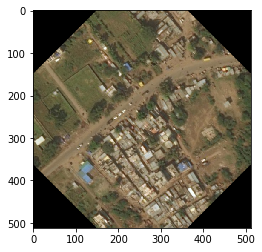

In [ ]:
rotate=iaa.Affine(rotate=(45))
image=rotate.augment_image(imread(train_img_paths[2]))
plt.imshow(image)

In [ ]:
image.shape


(512, 512, 3)

In [ ]:
def mirror_border(images, n):
    """mirrors border n border pixels on each side and corner:
        4D [num_images, image_height, image_width, num_channel]
        or 3D [num_images, image_height, image_width]
    returns:
        4D input: [num_patches, patch_size, patch_size, num_channel]
        3D input: [num_patches, patch_size, patch_size]
    """
    has_channels = (len(images.shape) == 4)
    if has_channels:
        return np.pad(images, ((0, 0), (n, n), (n, n), (0, 0)), "symmetric")
    else:
        return np.pad(images, ((0, 0), (n, n), (n, n)), "symmetric")


def rotate_imgs(imgs, angle):
    """safeguard to avoid useless rotation by 0"""
    if angle == 0:
        return imgs
    return rotate(imgs, angle=angle, axes=(1, 2), order=0)


def expand_and_rotate(imgs, angles, offset=0):
    """rotate some images by an angle, mirror image for missing part and expanding to output_size
        4D [num_images, image_height, image_width, num_channel]
        or 3D [num_images, image_height, image_width]
    angles: list of angle to rotate
    output_size: new size of image
    returns:
        4D input: [num_images * num_angles, output_size, output_size, num_channel]
        3D input: [num_images * num_angles, output_size, output_size]
    """

    has_channels = (len(imgs.shape) == 4)
    if not has_channels:
        imgs = np.expand_dims(imgs, -1)

    batch_size, height, width, num_channel = imgs.shape
    assert height == width

    output_size = height + 2 * offset
    padding = int(np.ceil(height * (np.sqrt(2) - 1) / 2)) + int(np.ceil(offset / np.sqrt(2)))

    print("Applying rotations: {} degrees... ".format(", ".join([str(a) for a in angles])))
    imgs = mirror_border(imgs, padding)
    rotated_imgs = np.zeros((batch_size * len(angles), output_size, output_size, num_channel))
    for i, angle in enumerate(angles):
        rotated_imgs[i * batch_size:(i + 1) * batch_size] = crop_imgs(rotate_imgs(imgs, angle), output_size)
    print("Done")

    if not has_channels:
        rotated_imgs = np.squeeze(rotated_imgs, -1)

    return rotated_imgs



In [ ]:
padding = int(np.ceil(512* (np.sqrt(2) - 1) / 2))
img=mirror_border(image,padding)

In [ ]:
p=np.zeros((1,512,512,3))
p[0]=image

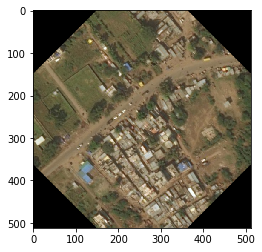

In [ ]:
plt.imshow(image)

In [ ]:
padding

107

In [ ]:
p.shape

(1, 512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


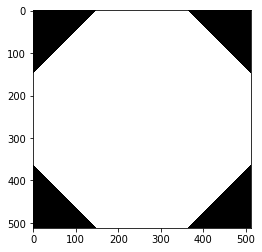

In [ ]:
p[0]=image
n=padding
np.pad(p,(0,0),(n,n),(n,n),(0,0),"symmetric")

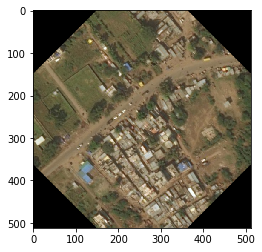

In [ ]:
plt.imshow(image)

In [ ]:
img=mirror_border(p,padding)
img.shape

(1, 726, 726, 3)

In [ ]:
len(train_img_paths)

10897

In [ ]:
i=0
for img_path in train_img_paths:
    
    # Construct the corresponding mask path
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    # Load the image and mask, and normalize it to 0-1 range 
    j = 8
    id = []
    id = ''.join(str(k) for k in random.sample(range(0,9),j))
    id=int(id)
    image=imread(img_path)
    mask=imread(mask_path)
    rotate=iaa.Affine(rotate=(90))
    image=rotate.augment_image(image)
    mask=rotate.augment_image(mask)
    io.imsave("./hdd/train_aug/%d_sat.jpg"%(id),image)
    io.imsave('./hdd/train_aug/%d_msk.png'%(id),mask)
    i=i+1
    print(i)



In [ ]:
i=0
for img_path in train_img_paths:
    
    # Construct the corresponding mask path
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    # Load the image and mask, and normalize it to 0-1 range 
    j = 8
    id = []
    id = ''.join(str(k) for k in random.sample(range(0,9),j)) 
    id=int(id)
    image=imread(img_path)
    mask=imread(mask_path)
    vflipper = iaa.Flipud(1.0) # vertically flip each input image 
    image = vflipper.augment_image(image) # vertically flip image 
    mask=vflipper.augment_image(mask)
    io.imsave("./hdd/train_new/%d_sat.jpg"%(id),image)
    io.imsave('./hdd/train_new/%d_msk.png'%(id),mask)
    i=i+1
    print(i)



In [ ]:
i=0
for img_path in train_img_paths:
    
    # Construct the corresponding mask path
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    # Load the image and mask, and normalize it to 0-1 range 
    j = 10
    id = []
    id = ''.join(str(k) for k in random.sample(range(0,10),j))
    id=int(id)
    image=imread(img_path)
    mask=imread(mask_path)
    blurer = iaa.GaussianBlur(3.0)
    image = blurer.augment_image(image) # blur image by a sigma of 3.0
    mask=blurer.augment_image(mask)
    io.imsave("./hdd/train_new/%d_sat.jpg"%(id),image)
    io.imsave('./hdd/train_new/%d_msk.png'%(id),mask)
    i=i+1
    print(i)



In [ ]:
i=0
for img_path in train_img_paths:
    
    # Construct the corresponding mask path
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    # Load the image and mask, and normalize it to 0-1 range 
    j = 7
    id = []
    id = ''.join(str(k) for k in random.sample(range(0,10),j))  
    id=int(id)
    image=imread(img_path)
    mask=imread(mask_path)
    perspective = iaa.PerspectiveTransform(scale=(0.075) )
    image = perspective.augment_image(image) 
    mask=perspective.augment_image(mask)
    io.imsave("./hdd/train_new/%d_sat.jpg"%(id),image)
    io.imsave('./hdd/train_new/%d_msk.png'%(id),mask)
    i=i+1
    print(i)


In [ ]:
from data import *

In [ ]:
data_gen_args=dict(rotation_range=0.2,
                  width_shift_range=0.05,
                  height_shift_range=0.05,
                  shear_range=0.05,
                  zoom_range=0.05,
                  horizontal_flip=True,
                  fill_mode='nearest')

In [ ]:
myGenerator=trainGenerator(20,'./hdd/train_aug/','image','label',data_gen_args,save_to_dir='./hdd/aug')